In [1]:
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import objectives
from keras import backend as K
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, Callback

Using TensorFlow backend.


In [3]:
import numpy as np
import pickle
import os
import pandas as pd

new_df = pd.read_csv(os.path.join("..","..","data","TA_User_Reviws_Korea_all_v2_new_df.csv"))
new_df = new_df.drop(['location_name'], axis=1)
new_df.head() 

,locationId,rated_count,average_photonum,average_rating,userID,users_mean_rating,user_reviewcount,rating,placeType,createdDate,islocal,photonum
0,299152,13,2.846154,3.692308,4842,3.677083,96,5,ACCOMMODATION,20171009,1,12
1,299152,13,2.846154,3.692308,9212,3.791667,240,3,ACCOMMODATION,20180306,1,0
2,299152,13,2.846154,3.692308,14262,4.500000,2,4,ACCOMMODATION,20121220,0,1
3,299152,13,2.846154,3.692308,20235,3.000000,4,1,ACCOMMODATION,20161127,0,4
4,299152,13,2.846154,3.692308,21432,4.200000,5,4,ACCOMMODATION,20120416,0,0


In [4]:
class PlotLosses(Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.show();
        
plot_losses = PlotLosses()

In [5]:
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []

    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        
history = LossHistory()

In [6]:
# encoder/decoder network size
batch_size=370
original_dim=6170 # number of movies
intermediate_dim=600
latent_dim=200
nb_epochs=20
epsilon_std=1.0

In [7]:
# encoder network
x=Input(batch_shape=(batch_size,original_dim))
h=Dense(intermediate_dim, activation='tanh')(x)
z_mean=Dense(latent_dim)(h)
z_log_var=Dense(latent_dim)(h)

In [8]:
# sampling from latent dimension for decoder/generative part of network
def sampling(args):
    _mean,_log_var=args
    epsilon=K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=epsilon_std)
    return _mean+K.exp(_log_var/2)*epsilon

z= Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

In [9]:
# decoder network
h_decoder=Dense(intermediate_dim, activation='tanh')
x_bar=Dense(original_dim,activation='softmax') 
h_decoded = h_decoder(z) 
x_decoded = x_bar(h_decoded)

In [10]:
# build and compile model
vae = Model(x, x_decoded)

def vae_loss(x,x_bar):
    reconst_loss=original_dim*objectives.binary_crossentropy(x, x_bar)
    kl_loss= -0.5*K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return kl_loss + reconst_loss

vae.compile(optimizer='adam', loss=vae_loss)

In [11]:
x_train = pickle.load( open( os.path.join("..","..","data","train_data.file"), "rb" ) )
print("number of training users: ", x_train.shape[0])

x_val = pickle.load( open(os.path.join("..","..","data","val_data.file"), "rb" ) )
x_val = x_val.todense() 

number of training users:  50870


In [12]:
def nn_batch_generator(x, y, batch_size, steps_per_epoch):
    number_of_batches = steps_per_epoch/batch_size
    counter=0
    shuffle_index = np.arange(np.shape(y)[0])
    np.random.shuffle(shuffle_index)
    x =  x[shuffle_index, :]
    y =  y[shuffle_index, :]
    while 1:
        index_batch = shuffle_index[batch_size*counter:batch_size*(counter+1)]
        x_batch = x[index_batch,:].todense() # returns a matrix
        y_batch = y[index_batch,:].todense()
        counter += 1
        yield (np.array(x_batch),np.array(y_batch))
        if (counter >= number_of_batches):
            counter=0

In [13]:
weightsPath = os.path.join("..","tmp","weights.hdf5")
checkpointer = ModelCheckpoint(filepath=weightsPath, verbose=1, save_best_only=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

In [118]:
vae.fit_generator(nn_batch_generator(x_train, x_train, batch_size, 50870), 
                  samples_per_epoch=50870, nb_epoch=nb_epochs, 
                  validation_data=(x_val, x_val), 
                  callbacks=[checkpointer, reduce_lr, plot_losses])

/Users/apple/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  after removing the cwd from sys.path.
/Users/apple/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., validation_data=(matrix([[..., callbacks=[<keras.ca..., steps_per_epoch=50870, epochs=20)`
  after removing the cwd from sys.path.


Epoch 1/20
  137/50870 [..............................] - ETA: 2:21:17 - loss: 11.4836

InvalidArgumentError:  Incompatible shapes: [180] vs. [370]
	 [[node gradients_5/loss_5/dense_37_loss/vae_loss/weighted_loss/mul_grad/Mul_1 (defined at /Users/apple/opt/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3009) ]] [Op:__inference_keras_scratch_graph_22009]

Function call stack:
keras_scratch_graph


<Figure size 432x288 with 0 Axes>

성능 테스트

In [ ]:
x_test_matrix = pickle.load( open( "test_data.file", "rb" ) )
x_test_matrix = x_test_matrix.todense()  # 1s and 0s per user
x_test = np.squeeze(np.asarray(x_test_matrix))

x_test_reconstructed = vae.predict(x_test, batch_size=batch_size)  # float values per user


# no concept of held out items in the test set, calculating overall
def recallatk(x_test, x_test_reconstructed, k):
	recall_values = []
	total_recall = 0.0
	for i in range(len(x_test)):
		top_rated_movies_idx = [i for i, x in enumerate(x_test[i].tolist()) if x == 1.0]

		if len(top_rated_movies_idx) == 0:
			#print("test user has no 1 rated movies: ", i)
			continue

		sorted_ratings = x_test_reconstructed[i].tolist()
		top_predicted_movies_idx = sorted(range(len(sorted_ratings)), key=lambda i: sorted_ratings[i])[-k:]
		
		sum = 0.0
		for i in range(0, k):
			if top_predicted_movies_idx[i] in top_rated_movies_idx:
				sum+=1.0
		recall = sum/float(min(k, len(top_rated_movies_idx)))
		total_recall += recall
		recall_values.append(recall)
	return total_recall/float(len(recall_values))

def ndcgatk(x_test, x_test_reconstructed, k):
	ndcg_values = []
	total_ndcg = 0.0
	best  = 0.0
	for i in range(len(x_test)):
		top_rated_movies_idx = [i for i, x in enumerate(x_test[i].tolist()) if x == 1.0]
		
		if len(top_rated_movies_idx) == 0:
			#print("test user has no 1 rated movies: ", i)
			continue
		sorted_ratings = x_test_reconstructed[i].tolist()
		top_predicted_movies_idx = sorted(range(len(sorted_ratings)), key=lambda i: sorted_ratings[i])[-k:]
		sum_ndcg = 0
		for i in range(0, k):
			if top_predicted_movies_idx[i] in top_rated_movies_idx:
				ndcg = 1/(math.log(i+2))
			else:
				ndcg = 0
			sum_ndcg += ndcg

		total_ndcg += sum_ndcg
		ndcg_values.append(sum_ndcg)

	ndcg_values = np.array(ndcg_values)
	max_ndcg = ndcg_values.max()
	ndcg_values = ndcg_values / max_ndcg 
	total_ndcg = np.sum(ndcg_values)

	return total_ndcg/float(len(ndcg_values))

print("NDCG at 100: ", ndcgatk(x_test, x_test_reconstructed, 100))

#recall at 20:  0.542023083825468
print("recall at 20: ", recallatk(x_test, x_test_reconstructed, 20))

#recall at 50:  0.5759154842447732
print("recall at 50: ", recallatk(x_test, x_test_reconstructed, 50))

# 전체학습 시키기

In [ ]:
x_train = pickle.load( open( os.path.join("..","..","data","all_data.file"), "rb" ) )
print("number of training users: ", x_train.shape[0])

x_val = pickle.load( open(os.path.join("..","..","data","val_data.file"), "rb" ) )
x_val = x_val.todense() 

In [ ]:
weightsPath = os.path.join("..","tmp","weights_all.hdf5")
checkpointer = ModelCheckpoint(filepath=weightsPath, verbose=1, save_best_only=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

In [ ]:
vae.fit_generator(nn_batch_generator(x_train, x_train, batch_size, 50870), 
                  samples_per_epoch=50870, nb_epoch=nb_epochs, 
                  validation_data=(x_val, x_val), 
                  callbacks=[checkpointer, reduce_lr, plot_losses])

# vector 뽑기

In [48]:
x_all_matrix = pickle.load(open(os.path.join("..","..","data","all_data.file"), "rb" ) )
x_all_matrix = x_all_matrix.todense()  # 1s and 0s per user
x_all = np.squeeze(np.asarray(x_all_matrix))

In [73]:
encoder = Model(x, z_mean)
x_all_encoded = vae.predict(x_all, batch_size=batch_size) 
print(x_all_encoded.shape) # should be  X 200

InvalidArgumentError:  Incompatible shapes: [10,200] vs. [370,200]
	 [[node lambda_6/mul_1 (defined at /Users/apple/opt/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3009) ]] [Op:__inference_keras_scratch_graph_13692]

Function call stack:
keras_scratch_graph


In [ ]:
# with open(os.path.join("..","..","data",'genome_embed.npy'), 'wb') as f:
#     np.save(f, np.array(x_test_encoded[1].tolist()))

In [55]:
# ! pip install bhtsne

     |████████████████████████████████| 86 kB 387 kB/s eta 0:00:01
  Created wheel for bhtsne: filename=bhtsne-0.1.9-cp37-cp37m-macosx_10_9_x86_64.whl size=58383 sha256=2a0812650de9dfd28333cd752a71f9c26721355fafb5e6133e054f7119ea8add
  Stored in directory: /Users/apple/Library/Caches/pip/wheels/e4/4c/71/26b7b0736d179d6bfe9d753629955515bf7ba7c1c8a8d98cb4
Successfully built bhtsne


In [56]:
from sklearn.cluster import KMeans
#from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from bhtsne import tsne

In [57]:
kmeans = KMeans(n_clusters=10, random_state=0).fit(x_test_encoded)
x_test_cluster_labels = kmeans.labels_

In [58]:
x_test_2_embedded = tsne(x_test_encoded.astype('float64'))
print(x_test_2_embedded.shape)

(10000, 2)


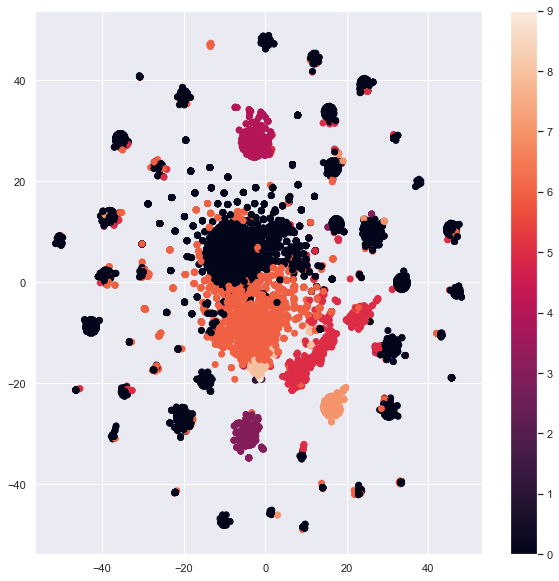

In [59]:
plt.figure(figsize=(10, 10))
plt.scatter(x_test_2_embedded[:, 0], x_test_2_embedded[:, 1], c=x_test_cluster_labels)
plt.colorbar()
plt.show()